In [7]:
import numpy as np
import matplotlib.pyplot as pyp
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.mlab as mlab
import os
import corner
import sys
import pandas as pd
sys.path.append("/u/project/bern/swissel/nutau/nutau_acceptance/03_Detector")
import tau_Shower_Efield_Sim_lib as taulib
%matplotlib inline
cmap = mpl.cm.get_cmap('inferno')

threshold_voltage_snr 5.0


In [8]:
import sys
sys.path.append(os.environ['TAU_DIR'] + "/nutau_acceptance/03_Detector/")
sys.path.append(os.environ['TAU_ACC_DET_DIR'] + "/anita/anita-1/")
import tau_Shower_Efield_Sim_lib as taulib
#pyp.style.use('seaborn-talk')
pyp.rcParams['font.size']=18
os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/anita-1/"
print os.environ['TAU_ACC_DET_DIR'] 

/u/project/bern/swissel/nutau/det_files//anita/anita-1/


In [20]:
def read_det_acceptance_files(finame1, finame2, en1, en2):
    fi1 = np.load(finame1)
    
    # acceptance calculated by the monte carlo at various levels
    # maximum geometric acceptance in km^2 sr
    A_Omega_start = fi1['A_Omega_start']
    # acceptance that includes the exit probability in km^2 sr
    A_Omega_exit  = fi1['A_Omega_exit']
    # acceptance that includes the tau decay range probabilitiy and tau exit probability in km^2 sr
    A_Omega_range = fi1['A_Omega_range']
    # acceptance that includes the tau exit, decay range probabilities and probability that the event triggers the detector in km^2 sr
    A_Omega_trig  = fi1['A_Omega_trig']
    # the energy in log( energy / eV)
    log_energy = np.log10(en1*pow(10., en2))
    # the number of events triggered
    N_triggered = fi1['N_triggered']
    # the number of events thrown in the Monte Carlo
    N_events_start = fi1['N_events_start']

    fi2 = np.load(finame2)
    # the noise voltage from the sum of the noise powers from the galaxy, the amplitired, and thermal noise
    noise_voltage = fi2['noise_voltage']
    # an array of useful information about the events that triggered, see below
    triggered_events = fi2['triggered_events']
    # the binned emergence angles used to calculate the differential acceptance
    emerge_angle_bins = fi2['emerge_angle_bins']
    # the binned number of sims in the emergence angle bins
    nsim_emerge_angle = fi2['nsim_emerge_angle']
    
    if( N_triggered > 0):
	# each of these arrays are the event level data for each event that triggered the detector
        # energy of the emerging tau in log(energy/eV)
        log10_tau_energy = triggered_events[:,0]
	# distance from the exit point to the detector calculated with a curved earth geometry in km
        dist_exit_to_detector = triggered_events[:,1]
	# distance from the exit point to the decay point in km 
        X0_dist = triggered_events[:,2]
	# distance from the decay point to the detector in km
        dist_decay_to_detector = triggered_events[:,3]
	# peak voltage at the antenna
        Peak_Voltage = triggered_events[:,4]
	# view angle from the tau lepton direction at the exit point
        exit_view_angle = triggered_events[:,5]
	# view angle from the tau decay point
        decay_view_angle = triggered_events[:,6]
	# zenith angle from the vertical at the exit point
        zenith_angle_exit = triggered_events[:,7]
	# zenith angle from the vertical at the decay point
        zenith_angle_decay = triggered_events[:,8]
	# zenith angle from the vertical at the exit point
        zenith_angle_geom = triggered_events[:,9]
	# decay altitude above the ice/ocean/ground surface
        decay_altitude = triggered_events[:,10]
	# probability that the tau exited 
        P_LUT = triggered_events[:,11]
	# probability that the tau decayed within the range of the detector 
        P_range = triggered_events[:,12]
	# probability that the tau event triggered the detector.
        P_det = triggered_events[:,13]
        
        return A_Omega_start, A_Omega_exit, A_Omega_range, A_Omega_trig, log_energy, \
            noise_voltage, log10_tau_energy, dist_exit_to_detector, X0_dist, dist_decay_to_detector, Peak_Voltage, \
            exit_view_angle, decay_view_angle, zenith_angle_exit, zenith_angle_decay, zenith_angle_geom, decay_altitude, \
            P_LUT, P_range, P_det, N_events_start, emerge_angle_bins, nsim_emerge_angle
    
    return A_Omega_start, A_Omega_exit, A_Omega_range, A_Omega_trig, log_energy,\
            None, None, None, None, None, None,\
            None, None, None,\
            None, None, None, None, None,\
            None, None, None, None, None, None,\
            None, None, None, None, None, None

In [21]:
def read_geom_acceptance_file(altitude):
    acceptance_arrays = np.load(os.environ['TAU_ACC_GEOM_DIR'] + "/geom_%d_km_5_deg_10M_ev.npz"%(altitude))
    k_y = acceptance_arrays['k_y']
    k_x = acceptance_arrays['k_x']
    k_z = acceptance_arrays['k_z']
    z_exit = acceptance_arrays['z_exit']
    cos_theta_exit = acceptance_arrays['cos_theta_exit']
    input_args = acceptance_arrays['input_args']
    x_exit = acceptance_arrays['x_exit']
    A0 = acceptance_arrays['A0']
    A_geom = acceptance_arrays['A_geom']
    exit_view_angle = acceptance_arrays['exit_view_angle']
    cosE = z_exit/taulib.Earth_radius
    zero_vector = np.zeros(len(x_exit))
    dist_exit_to_detector = taulib.get_distance_to_detector(x_exit, zero_vector, z_exit,
                         zero_vector, zero_vector,
                         zero_vector + taulib.Earth_radius + altitude )
    return k_x, k_y, k_z, x_exit, z_exit, cos_theta_exit, input_args,\
           A0, A_geom, exit_view_angle, cosE, dist_exit_to_detector

In [22]:
# filter for smoothing the acceptance histograms
def savitzky_golay(y, window_size, order, deriv=0, rate=1):

    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [23]:
def differential_histogram_emergence_angle(zenith_angle_geom, zenith_angle_particle, N, P_LUT, P_range, P_det, binwidth=0.3):
    # Calculate the emergence angles from the particles
    emerge_angle_geom = 90. - zenith_angle_geom
    emerge_angle_particle = 90. - zenith_angle_particle
    
    emerge_angle_bins = np.arange(0, 90., binwidth)
    diff_hist = np.zeros(len(emerge_angle_bins))
    for k, eap in enumerate(emerge_angle_particle):
        ea = emerge_angle_geom[k]
        idx = np.argmin(abs(emerge_angle_bins - ea))
        # the histograms are binned in emerge_angle (geometry)
        # the probabilities are binned in the particle emergence angle
        diff_hist[idx] += P_LUT[k]  * P_range[k] * P_det[k] / float(N) /binwidth
    
    return emerge_angle_bins, diff_hist

def acceptance_emergence_angle(altitude, icethick, en1, en2, f_Lo, f_High, 
                                    gain, nphased, nbins_hist=300, sublabel='',
                                    cross='mid',eloss = 'std', Re=6356.7523,
                                    color=None,linestyle=None,plot=True,alpha=1.0,**kwargs):
    
    finame1 = os.environ['TAU_ACC_DET_DIR'] +"detector_acceptance_altitude_%d_km_%1.1fkm_ice_%sCS_%sEL_%de+%d_eV_%d-%dMHz_%2.1fdBi_%1.1fantennas.npz"%( 
        altitude,icethick,cross, eloss, en1,en2,f_Lo,f_High,gain,nphased)
    finame2 = os.environ['TAU_ACC_DET_DIR'] + "detector_acceptance_altitude_%d_km_%1.1fkm_ice_%sCS_%sEL_%de+%d_eV_%d-%dMHz_%2.1fdBi_%1.1fantennas_events.npz"%(
        altitude,icethick,cross,eloss,en1,en2,f_Lo,f_High,gain,nphased)
    #print finame1
    #print finame2

    A_Omega_start, A_Omega_exit, A_Omega_range, A_Omega_trig, log_energy, \
            noise_voltage, log10_tau_energy, dist_exit_to_detector, X0_dist, dist_decay_to_detector, Peak_Voltage, \
            exit_view_angle, decay_view_angle, zenith_angle_exit, zenith_angle_decay, zenith_angle_geom, decay_altitude, \
            P_LUT, P_range, P_det, N_events_start, emerge_angle_bins, nsim_emerge_angle = \
            read_det_acceptance_files(finame1, finame2, en1, en2)
            
    A_Omega_trig *= 1e10        # convert from km^2 sr to cm^2 sr
    binwidth=0.3
    emergeang, probdensity = differential_histogram_emergence_angle(zenith_angle_geom, zenith_angle_exit, N_events_start, 
                                                                         P_LUT, P_range, P_det, binwidth=binwidth)
    
    # calculate the analytical <A\Omega>0 from Motloch et al
    Re = Re + icethick
    h = altitude
    view_ang_cut = 5.0
    AOmega0 = 2*np.pi**2 * pow(np.sin(view_ang_cut*np.pi/180.),2) * \
                    (pow(altitude*(2.*Re + altitude), 1.5) - altitude**2 *(3.*Re + altitude))/(3.*Re+altitude)

    diff_acceptance = AOmega0 * probdensity * 1e10 # convert from km^2 sr to cm^2 sr
    pyp.loglog(emergeang, diff_acceptance,
                     color=color,linestyle=linestyle,label=sublabel,linewidth=2, alpha=alpha)
    
    pyp.xlabel(r"Emergence Angle $\theta_{em}$ (deg.)")
    pyp.ylabel(r"$\frac{d\langle A\Omega\rangle}{d\theta_{em}}$ (cm$^2$ sr/deg.)") 
    
    return emergeang, diff_acceptance

In [24]:
def test(altitude, icethick, en1, en2, f_Lo, f_High, 
                                    gain, nphased, nbins_hist=300, sublabel='',
                                    cross='mid',eloss = 'std',
                                    color=None,linestyle=None,plot=True,alpha=1.0,**kwargs):
    
    finame1 = os.environ['TAU_ACC_DET_DIR'] +"detector_acceptance_altitude_%d_km_%1.1fkm_ice_%sCS_%sEL_%de+%d_eV_%d-%dMHz_%2.1fdBi_%1.1fantennas.npz"%( 
        altitude,icethick,cross, eloss, en1,en2,f_Lo,f_High,gain,nphased)
    finame2 = os.environ['TAU_ACC_DET_DIR'] + "detector_acceptance_altitude_%d_km_%1.1fkm_ice_%sCS_%sEL_%de+%d_eV_%d-%dMHz_%2.1fdBi_%1.1fantennas_events.npz"%(
        altitude,icethick,cross,eloss,en1,en2,f_Lo,f_High,gain,nphased)
    #print finame1
    #print finame2

    A_Omega_start, A_Omega_exit, A_Omega_range, A_Omega_trig, log_energy, \
            noise_voltage, log10_tau_energy, dist_exit_to_detector, X0_dist, dist_decay_to_detector, Peak_Voltage, \
            exit_view_angle, decay_view_angle, zenith_angle_exit, zenith_angle_decay, zenith_angle_geom, decay_altitude, \
            P_LUT, P_range, P_det, N_events_start, emerge_angle_bins, nsim_emerge_angle = \
            read_det_acceptance_files(finame1, finame2, en1, en2)
            
    #A_Omega_trig *= 1e10        
        
    #pyp.figure(1)
    print 90.- max(zenith_angle_geom), 90.-max(zenith_angle_exit)
    emerge_angle = 90. - zenith_angle_geom
    emerge_angle_particle = 90. - zenith_angle_exit
    binwidth=0.3
    bins = np.arange(0., 90. + binwidth, binwidth)
    weights = P_LUT * P_range * P_det
         
    ntrig, binstrig = np.histogram(emerge_angle, bins, normed=False, weights = weights)
    ntrig_particle, binstrig_particle = np.histogram(emerge_angle_particle, bins, normed=False, weights = weights)
    
    emergeang = binstrig[:-1] + binwidth/2.
    emergeang_particle = binstrig_particle[:-1] + binwidth/2.

    diffgeom_hist = np.zeros(len(emergeang))
    diff_hist = np.zeros(len(emergeang))
    norm_hist = np.zeros(len(emergeang))
    
    # calculate the differential acceptance
    Re = 6356.7523
    h = 37.0
    view_ang_cut = 5.0
    #print emergeang
    for k, ea in enumerate(emergeang):
        za = 90. - ea
        #print ea, za
        x = Re * pow( (1. + h/Re)**2 - pow(np.cos(ea*np.pi/180.), 2), 0.5 ) - Re * np.sin(ea*np.pi/180.)
        diffgeom_hist[k] = 2*np.pi**2 * Re**2 * np.cos(za*np.pi/180.)\
                            * np.cos(ea*np.pi/180.)*pow(np.sin(view_ang_cut*np.pi/180.),2)\
                            * x*x / (x + Re * np.sin(ea *np.pi/180.)) / (Re+h) 

    for k, eap in enumerate(emerge_angle_particle):
        #print b
        ea = emerge_angle[k]
        idx = np.argmin(abs(emergeang - ea))
        # the histograms are binned in emerge_angle (geometry)
        # the probabilities are binned in the particle emergence angle
        norm_hist[idx] += 1.
        diff_hist[idx] += P_det[k] * P_LUT[k] * P_range[k]
   
    # total number of triggered events is just the number of entries
    sum_ntrig = len(emerge_angle)
    diffntrig_emerge_particle = np.array(ntrig_particle, dtype=float)/float(len(emerge_angle_particle))
    diffntrig_emerge = np.array(ntrig, dtype=float)/float(len(emerge_angle))
    
    for k, ea in enumerate(emergeang):
        diff_hist[idx] = diffgeom_hist[k] * diff_hist[k] 
    
    pyp.figure(2)
    pyp.loglog(emergeang*np.pi/180., diff_hist, label=r"$a0 * sum(P(\theta_{em}^{\sim})$")
    pyp.xlabel(r"$\theta_{em}$ (rad.)")
    pyp.ylabel(r"$\frac{dA\Omega_{trig}}{d\theta_{em}} (km^2 sr / rad.)$")
    
    pyp.figure(1)
    diffacc_emerge = ntrig*A_Omega_trig/len(emerge_angle)/binwidth
    pyp.loglog(emergeang, diffntrig_emerge,
                     color=color,linestyle=linestyle,linewidth=2, alpha=alpha, 
                     label = r"Triggered events binned in $\theta_{em}$")
    pyp.loglog(emergeang_particle, diffntrig_emerge_particle, label = r"Triggered events binned in $\theta_{em}^{\sim}$")
    pyp.legend(loc=[1.1,0.4])
    pyp.xlabel(r"Emergence Angle $\theta$ (deg.)")
    pyp.ylabel(r"$N(\theta)/\Sigma(N(\theta)$")
    
    pyp.figure(2)
    print len(diff_hist), len(nsim_emerge_angle)
    for k,n in enumerate(nsim_emerge_angle[:-1]):
        if( n == 0):
            diff_hist[k] = diff_hist[k]
            print k, diff_hist[k]
        else:
            diff_hist[k] = diff_hist[k] /n
           
    #diff_hist=diff_hist/sum(norm_hist)
    pyp.plot(emergeang*np.pi/180., diff_hist, label=r"$a_0 / N_{sim}(\theta_{em}) sum(P(\theta_{em}^{\sim}))$")
    #print diff_hist
    print A_Omega_start, A_Omega_exit, A_Omega_range, A_Omega_trig
    print sum(diffgeom_hist)*binwidth*np.pi/180., A_Omega_start
    print np.nansum(diff_hist)*binwidth*np.pi/180., A_Omega_trig
    pyp.legend(loc=[1.1, 0.5])
    
    pyp.figure(4)
    pyp.semilogy(emergeang, diffgeom_hist)
    pyp.xlabel(r"$\theta_{em}$ (rad.)")
    pyp.ylabel(r"$\frac{dA\Omega_{geom}}{d\theta_{em}} (km^2 sr / rad.)$")
     
    pyp.figure(3)
    #print emerge_angle_bins
    pyp.semilogy(emergeang - binwidth/2., norm_hist, 'o-',label='Triggered')
    pyp.xlabel(r"$\theta_{em}$ (deg.)")
    pyp.ylabel(r"N")
    pyp.plot(emerge_angle_bins-0.5*(emerge_angle_bins[1]-emerge_angle_bins[0]), nsim_emerge_angle, 'o-',
             label='Simulated')
    pyp.legend()
    #pyp.xlim(0,10)
    print sum(nsim_emerge_angle)
    
    pyp.figure(5)
    pyp.semilogy(emergeang , norm_hist/nsim_emerge_angle[:-1], 'o-')
    pyp.xlabel(r"$\theta_{em}$ (deg.)")
    pyp.ylabel(r"Ratio Trig to Sim'")
    
    pyp.figure(6)
    pyp.loglog(emergeang, diffgeom_hist * diff_hist/nsim_emerge_angle[:-1], 'o-',label='a0 * Ratio Trig to Sim')
    pyp.xlabel(r"$\theta_{em}$ (deg.)")
    #pyp.ylabel(r"N")
    #pyp.plot(emerge_angle_bins-0.5*(emerge_angle_bins[1]-emerge_angle_bins[0]), nsim_emerge_angle, 'o-',
    #         label='Simulated')
    pyp.legend()
    print np.sum(diffgeom_hist * diff_hist/nsim_emerge_angle[:-1]) * binwidth * np.pi/180.
    print np.sum(diffgeom_hist * norm_hist/nsim_emerge_angle[:-1]) * binwidth * np.pi/180.
    return emergeang, diffntrig_emerge

0.489516428655 0.0586026351006
300 301
0 0.0
1 0.9940767
2 29.3194008
3 61.5203275
4 68.6433216
5 66.5547975
6 66.1816855
7 65.9749854
8 58.5879224
9 0.0
10 28.6997763
11 16.8814974
12 11.4979011
13 7.4301118
14 5.3427633
15 3.4815619
16 2.4219312
17 1.6908256
18 1.1196866
19 0.7676057
20 0.5019068
21 0.3234916
22 0.1981104
23 0.1356579
24 0.1070364
25 0.0662161
26 0.0520775
27 0.0419554
28 0.0320272
29 0.0241448
30 0.019177
31 0.016774
32 0.011853
33 0.011558
34 0.0102654
35 0.0089508
36 0.0070626
37 0.0065938
38 0.0054136
39 0.0055982
40 0.004651
41 0.0026606
42 0.003495
43 0.0033446
44 0.0024224
45 0.0022122
46 0.00252
47 0.0016062
48 0.0017109
49 0.001881
50 0.0013404
51 0.0009045
52 0.000574
53 0.0009592
54 0.0007993
55 0.0008455
56 0.0010362
57 0.0007677
58 0.0005988
59 0.000452
60 0.0003834
61 0.0002506
62 0.0003276
63 0.0003306
64 0.0002112
65 0.0001038
66 9.78e-05
67 0.0001766
68 0.000142
69 2.65e-05
70 0.0001101
71 9.11e-05
72 6.68e-05
73 7.47e-05
74 4.69e-05
75 8.5e-05
76 6.

/u/nobackup/bern/swissel/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in divide
/u/nobackup/bern/swissel/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in divide
/u/nobackup/bern/swissel/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in divide
/u/nobackup/bern/swissel/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in divide
/u/nobackup/bern/swissel/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in divide
/u/nobackup/bern/swissel/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in divide
/u/nobackup/bern/swissel/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in divide
/u

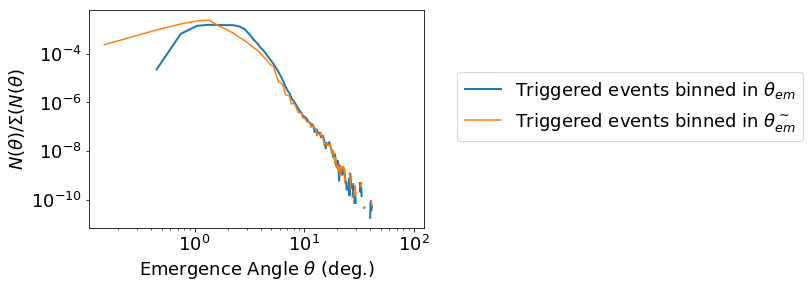

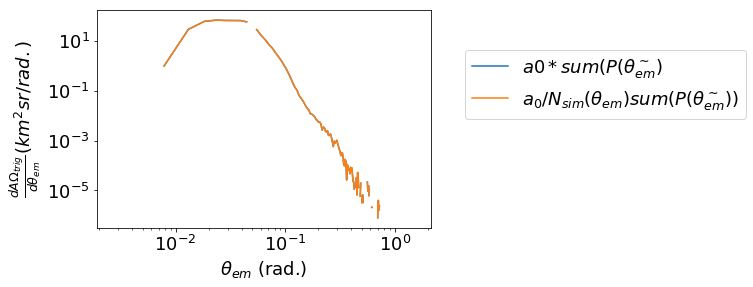

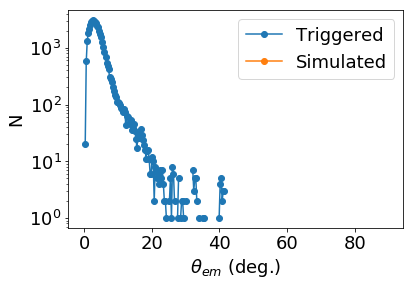

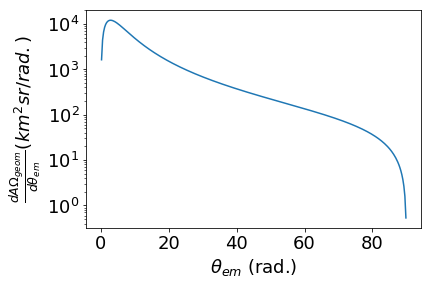

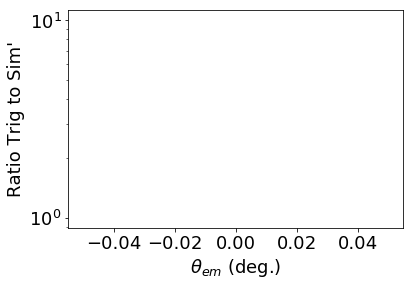

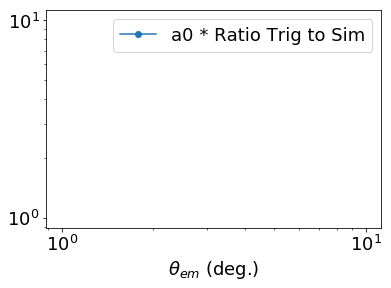

In [25]:
os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/anita-3/"
emergeang, diffntrig_emerge = test(37, 2, 3, 19, 180, 1200, 10., 1., "mid", "std")
#pyp.xlim(0.25)

In [26]:
np.array(np.array([5,64,2,6]), dtype=float)

array([  5.,  64.,   2.,   6.])

In [27]:
crosslabel={'low':'low', 'mid':'mid.', 'upp':'upp.'}
elosslabel={'std':"ALLM", 'low':"ASW"}

In [28]:
icethick=4.0
f_Lo = 180
f_High=1200
gain=10.
nphased=1
altitude=37
cross = 'mid'
eloss='std'
os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/anita-3/"

In [29]:
def figure(altitude, icethick, f_Lo, f_High, gain, nphased, cross, eloss):
    pyp.figure(1, figsize=(8,8))

    en1 = 3
    en2 = 17
    #plot_dist_exit_to_detector_geom(altitude, label='')

    norm = mpl.colors.Normalize(17,22)

    ang, diffacc = acceptance_emergence_angle(altitude, icethick, en1, en2, 
                                    f_Lo, f_High, gain, nphased, 
                                    sublabel='$10^{%2.1f}$ eV'%np.log10(en1*pow(10,en2)),
                                    cross=cross,eloss = eloss,
                                    color = cmap(norm(17.)), linestyle='--')

    for e2 in np.arange(18., 22.):
        for e1 in np.array([1.,3.]):
            if e2 == 21. and e1 == 3.:
                continue

            if e1 == 1.:
                line = '-'
            else:
                line = '--'

            an, da = acceptance_emergence_angle(altitude, icethick, e1, e2, 
                                    f_Lo, f_High, gain, nphased, 
                                    sublabel='$10^{%2.1f}$ eV'%np.log10(e1*pow(10,e2)),
                                    color=cmap(norm(e2)), linestyle=line)

    pyp.figure(1, figsize=(10,8))
    #pyp.plot(ang, diffacc, 'k', linewidth=3, label='Total')
    #pyp.vlines([25.8, 27.8], 4e-8,2e-3,colors='k', linestyles='--', lw=2,alpha=0.6)
    pyp.vlines([26.8],4e2,0.2e10, colors='k', linestyles='-', lw=3, alpha=0.5)
    pyp.fill_betweenx([4e8,0.2e10], 25.8, 27.8,color='k', alpha=0.1)
    pyp.title("ANITA-I, %s $\sigma$, %s, %d km ice"%(crosslabel[cross], elosslabel[eloss],icethick))
    pyp.legend(framealpha=1.0, fontsize=14, labelspacing=0.1)
    pyp.xlim(0,40)
    pyp.ylim(4e2, 0.2e10)
    pyp.grid(True, which='both', alpha=0.1)
    pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_anita1_ice%dkm_%sCS_%sEL.pdf"%(icethick,cross,eloss),bbox_inches='tight')

(0.25, 40.0)

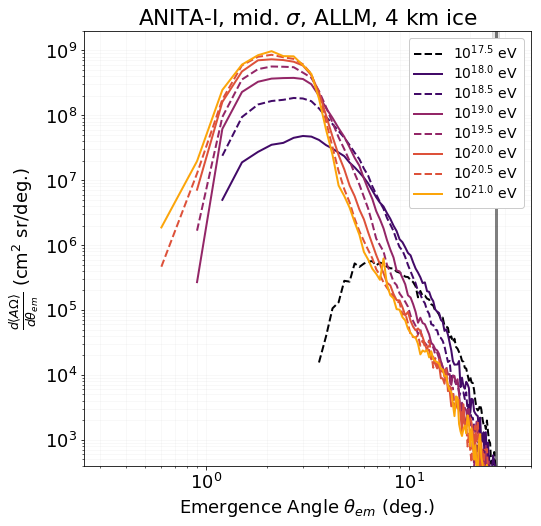

In [30]:
figure(altitude, icethick, f_Lo, f_High, gain, nphased, cross, eloss)
pyp.xlim(0.25)

In [82]:
'''for icethick in [2,3,4]:
    for cross in crosslabel.keys():
        for eloss in elosslabel.keys():
            print icethick, cross, eloss
            figure(altitude, icethick, f_Lo, f_High, gain, nphased, cross, eloss)
            pyp.clf()'''

'for icethick in [2,3,4]:\n    for cross in crosslabel.keys():\n        for eloss in elosslabel.keys():\n            print icethick, cross, eloss\n            figure(altitude, icethick, f_Lo, f_High, gain, nphased, cross, eloss)\n            pyp.clf()'

In [83]:
def comparison_single(altitude, icethick, f_Lo, f_High, gain, nphased, which, scenario):
    
    # set parameters based on which flight, anita1 or anita3
    if( which == 'anita1'):
        os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
        os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/anita-1/"
        subtitle = "ANITA-I"
        meas_emerge = [26.8]
        sigma_emerge = [25.8, 27.8]
    elif( which == 'anita3'):
        subtitle = "ANITA-III"
        pyp.vlines([34.6],4e-8,0.05, colors='k', linestyles='-', lw=3, alpha=0.5)
        meas_emerge = [34.6]
        sigma_emerge = [33.6, 35.6]
        os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
        os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/anita-3/"
    
    cols = ['#FF0800','#4447FF', '#960101', '#030196']
    alphs = [1.0, 0.85, 0.7, 0.55]
    #cols = ['#FF0800','#4447FF', '#FF0800','#4447FF',]
    cols = ['#000000', '#0000FF','#FF0000', '#0080ff' ]
    #alphs = [1.0, 1.0, 1.0, 1.0]
    #alphs = [1.0, 1.0, 0.75, 0.75]
    
    norm = mpl.colors.Normalize(17,20)
    pyp.figure(1, figsize=(8,8))
    #pyp.subplot(1,2,1)
    
    if( scenario == 'mid'):
        # solid lines are the reference models
        cross = 'mid'
        eloss = 'std'

        en1_arr = [3., 1., 1., 1.]
        en2_arr = [17., 18., 19., 20.]

        for i, e1 in enumerate(en1_arr):
            e2 = en2_arr[i]
            an, da = acceptance_emergence_angle(altitude, icethick, e1, e2, 
                                    f_Lo, f_High, gain, nphased, cross=cross, eloss=eloss,
                                    sublabel='$10^{%2.1f}$ eV'%np.log10(e1*pow(10,e2)),
                                    #color=cmap(norm(np.log10(e1) + e2)), linestyle='-', plot=True)
                                    color=cols[i], linestyle='-', alpha=alphs[i], plot=True)
            print 'Ref. $10^{%2.1f}$ eV'%np.log10(e1*pow(10,e2))
        pyp.title("%s, %d km ice, %s $\sigma$, %s"%(subtitle,icethick, crosslabel[cross], elosslabel[eloss]))
    elif( scenario == 'opt'):
        # dashed lines are the optimistic models
        cross = 'low'
        eloss = 'low'

        en1_arr = [3., 1., 1., 1.]
        en2_arr = [17., 18., 19., 20.]

        for i, e1 in enumerate(en1_arr):
            e2 = en2_arr[i]
            an, da = acceptance_emergence_angle(altitude, icethick, e1, e2, 
                                    f_Lo, f_High, gain, nphased, cross=cross, eloss=eloss,
                                    sublabel='$10^{%2.1f}$ eV'%np.log10(e1*pow(10,e2)),
                                    #color=cmap(norm(np.log10(e1) + e2)), linestyle='--', plot=True)
                                    color=cols[i], linestyle='-', alpha=alphs[i], plot=True)
            print 'Optim. $10^{%2.1f}$ eV'%np.log10(e1*pow(10,e2))
        pyp.title("%s, %d km ice, %s $\sigma$, %s"%(subtitle,icethick, crosslabel[cross], elosslabel[eloss]))
        pyp.legend(framealpha=1.0, fontsize=16, labelspacing=0.1)
    pyp.vlines(meas_emerge,5e1, 2e9, colors='k', linestyles='-', lw=3, alpha=0.5)
    pyp.fill_betweenx([5e1, 2e9], sigma_emerge[0], sigma_emerge[1],color='k', alpha=0.1)

    pyp.legend(framealpha=1.0, fontsize=16, labelspacing=0.1)
    pyp.xlim(0,38)
    pyp.ylim(5e1, 2e9)
    pyp.grid(True, which='both', alpha=0.1)

Ref. $10^{17.5}$ eV
Ref. $10^{18.0}$ eV
Ref. $10^{19.0}$ eV
Ref. $10^{20.0}$ eV
Optim. $10^{17.5}$ eV
Optim. $10^{18.0}$ eV
Optim. $10^{19.0}$ eV
Optim. $10^{20.0}$ eV


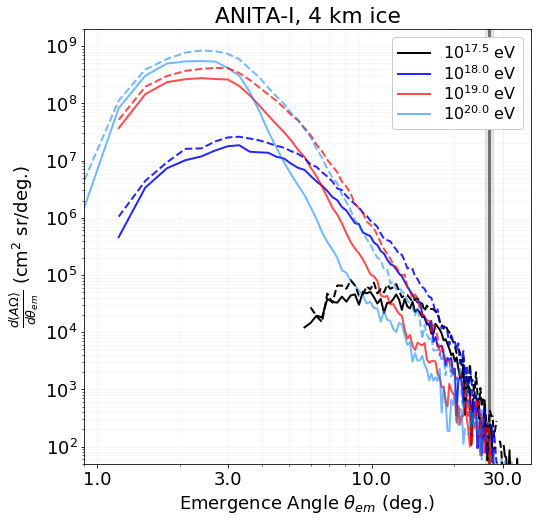

In [101]:
icethick=4.0

fig, ax = pyp.subplots(num=1,figsize=(8,8))#pyp.figure(i+1,figsize=(6,4))  
comparison(altitude, icethick, f_Lo, f_High, gain, nphased, "anita1")
ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
pyp.xlim(0.9)

pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_anita1_ice%dkm.pdf"%(icethick),bbox_inches='tight')

Ref. $10^{17.5}$ eV
Ref. $10^{18.0}$ eV
Ref. $10^{19.0}$ eV
Ref. $10^{20.0}$ eV


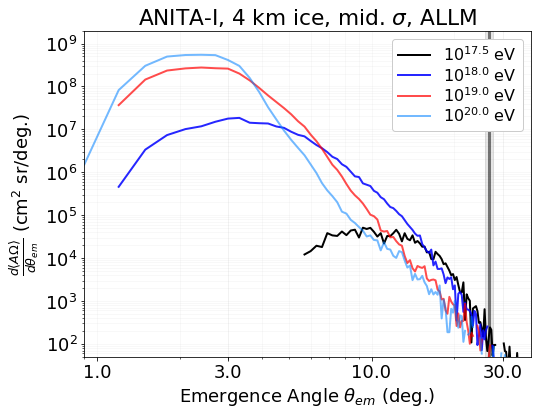

In [102]:
icethick=4.0

fig, ax = pyp.subplots(num=1,figsize=(8,6))#pyp.figure(i+1,figsize=(6,4))  
comparison_single(altitude, icethick, f_Lo, f_High, gain, nphased, "anita1", 'mid')
ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
pyp.xlim(0.9)

pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_anita1_ice%dkm_mid.pdf"%(icethick),bbox_inches='tight')

Optim. $10^{17.5}$ eV
Optim. $10^{18.0}$ eV
Optim. $10^{19.0}$ eV
Optim. $10^{20.0}$ eV


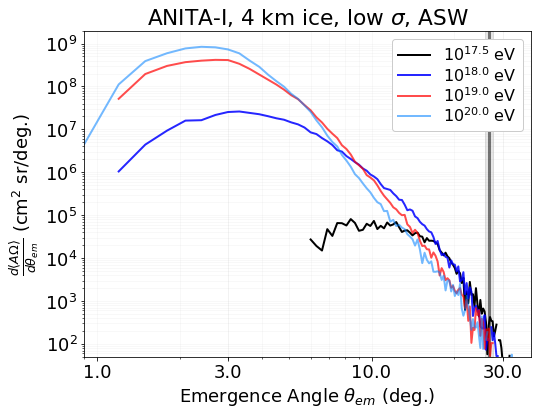

In [103]:
icethick=4.0

fig, ax = pyp.subplots(num=1,figsize=(8,6))#pyp.figure(i+1,figsize=(6,4))  
comparison_single(altitude, icethick, f_Lo, f_High, gain, nphased, "anita1", 'opt')
ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
pyp.xlim(0.9)
pyp.legend(framealpha=1.0, fontsize=16, labelspacing=0.1)

pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_anita1_ice%dkm_opt.pdf"%(icethick),bbox_inches='tight')

Ref. $10^{17.5}$ eV
Ref. $10^{18.0}$ eV
Ref. $10^{19.0}$ eV
Ref. $10^{20.0}$ eV
Optim. $10^{17.5}$ eV
Optim. $10^{18.0}$ eV
Optim. $10^{19.0}$ eV
Optim. $10^{20.0}$ eV


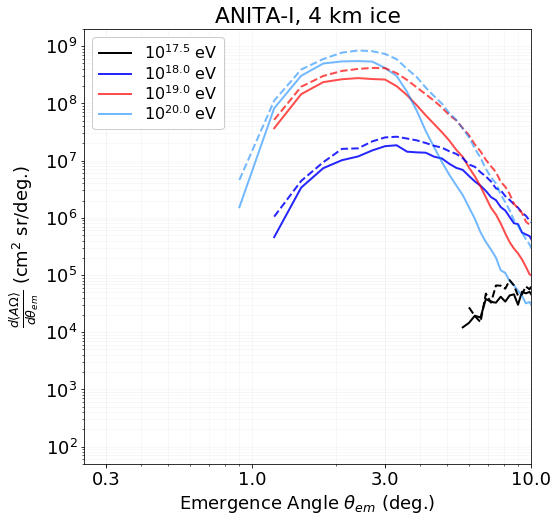

In [104]:
icethick=4.0
fig, ax = pyp.subplots(num=1,figsize=(8,8))#pyp.figure(i+1,figsize=(6,4))  
#pyp.figure(1, figsize=(8,8))
comparison(altitude, icethick, f_Lo, f_High, gain, nphased, "anita1")
pyp.xlim(0.25,10)
ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
pyp.xlim(0.25,10)


pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_anita1_ice%dkm_zoom.pdf"%(icethick),bbox_inches='tight')

Ref. $10^{17.5}$ eV
Ref. $10^{18.0}$ eV
Ref. $10^{19.0}$ eV
Ref. $10^{20.0}$ eV
Optim. $10^{17.5}$ eV
Optim. $10^{18.0}$ eV
Optim. $10^{19.0}$ eV
Optim. $10^{20.0}$ eV


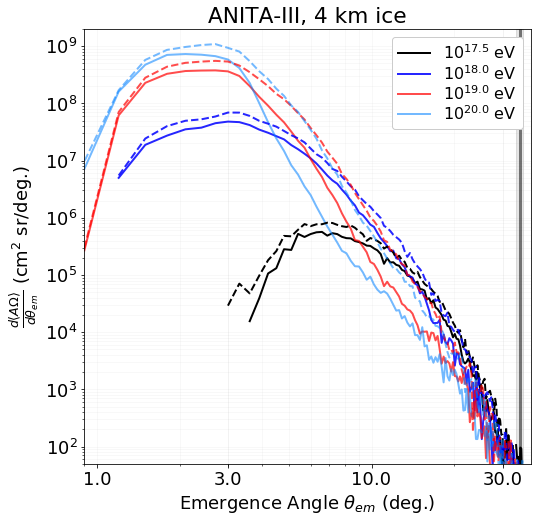

In [105]:
fig, ax = pyp.subplots(num=1,figsize=(8,8))#pyp.figure(i+1,figsize=(6,4))  
#pyp.figure(1, figsize=(8,8))
comparison(altitude, icethick, f_Lo, f_High, gain, nphased, "anita3")
ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
pyp.xlim(0.9)

pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_anita3_ice%dkm.pdf"%(icethick),bbox_inches='tight')

Ref. $10^{17.5}$ eV
Ref. $10^{18.0}$ eV
Ref. $10^{19.0}$ eV
Ref. $10^{20.0}$ eV


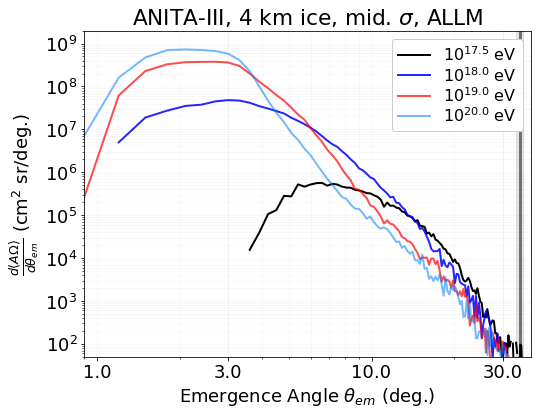

In [106]:
icethick=4.0

fig, ax = pyp.subplots(num=1,figsize=(8,6))#pyp.figure(i+1,figsize=(6,4))  
comparison_single(altitude, icethick, f_Lo, f_High, gain, nphased, "anita3", 'mid')
ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
pyp.xlim(0.9)
pyp.legend(framealpha=1.0, fontsize=16, labelspacing=0.1)
pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_anita3_ice%dkm_mid.pdf"%(icethick),bbox_inches='tight')

Optim. $10^{17.5}$ eV
Optim. $10^{18.0}$ eV
Optim. $10^{19.0}$ eV
Optim. $10^{20.0}$ eV


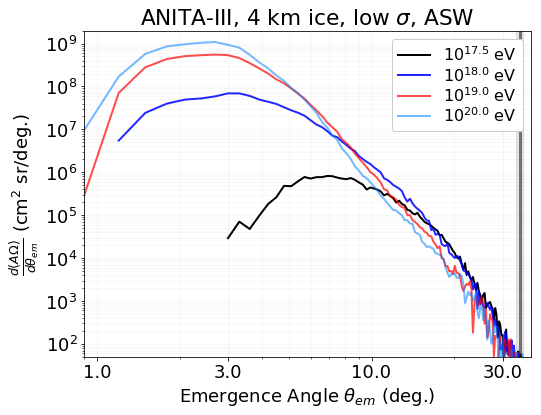

In [107]:
icethick=4.0

fig, ax = pyp.subplots(num=1,figsize=(8,6))#pyp.figure(i+1,figsize=(6,4))  
comparison_single(altitude, icethick, f_Lo, f_High, gain, nphased, "anita3", 'opt')
ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
pyp.xlim(0.9)
pyp.legend(framealpha=1.0, fontsize=16, labelspacing=0.1)
pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_anita3_ice%dkm_opt.pdf"%(icethick),bbox_inches='tight')

Ref. $10^{17.5}$ eV
Ref. $10^{18.0}$ eV
Ref. $10^{19.0}$ eV
Ref. $10^{20.0}$ eV
Optim. $10^{17.5}$ eV
Optim. $10^{18.0}$ eV
Optim. $10^{19.0}$ eV
Optim. $10^{20.0}$ eV


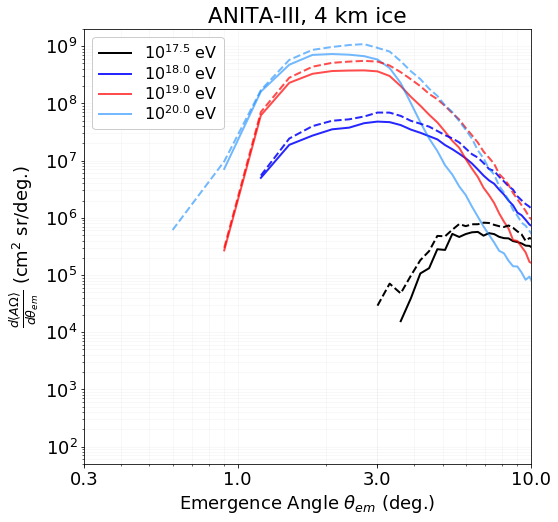

In [108]:
fig, ax = pyp.subplots(num=1,figsize=(8,8))#pyp.figure(i+1,figsize=(6,4))  
comparison(altitude, icethick, f_Lo, f_High, gain, nphased, "anita3")
#pyp.xlim(0,10)
ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
pyp.xlim(0,10)


pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_anita3_ice%dkm_zoom.pdf"%(icethick),bbox_inches='tight')

In [92]:
def cross_section_comparison(altitude, icethick, f_Lo, f_High, gain, nphased, e1, e2, which, eloss='std', suffix='', title=''):
    
    cols = ['green', 'red', 'blue']
    alphs = [1.0,1.0,1.0]
    linestyles=['-', '-', '-']
    
    # set parameters based on which flight, anita1 or anita3
    if( which == 'anita1'):
        os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
        os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/anita-1/"
        subtitle = "ANITA-I"
        meas_emerge = [26.8]
        sigma_emerge = [25.8, 27.8]
    elif( which == 'anita3'):
        subtitle = "ANITA-III"
        pyp.vlines([34.6],4e-8,0.05, colors='k', linestyles='-', lw=3, alpha=0.5)
        meas_emerge = [34.6]
        sigma_emerge = [33.6, 35.6]
        os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
        os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/anita-3/"
    elif( which == 'anita1_july2018'):
        os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
        os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/backup/decay_zenith_parm_6356p7523/"
        subtitle = "ANITA-I"
        meas_emerge = [26.8]
        sigma_emerge = [25.8, 27.8]
        linestyles=['--', '--', '--']
        suffix = ' 7/18 LUTs'
    elif( which == 'anita3_july2018'):
        subtitle = "ANITA-III"
        pyp.vlines([34.6],4e-8,0.05, colors='k', linestyles='-', lw=3, alpha=0.5)
        meas_emerge = [34.6]
        sigma_emerge = [33.6, 35.6]
        os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
        os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/backup/anita-3/"
        linestyles=['--', '--', '--']
        suffix = ' 7/18 LUTs'

    #alphs = [1.0, 1.0, 1.0, 1.0]
    #alphs = [1.0, 1.0, 0.75, 0.75]
    
    norm = mpl.colors.Normalize(17,20)
    #pyp.figure(1, figsize=(8,8))
    #pyp.subplot(1,2,1)
    
    # solid lines are the reference models
    cross = ['low','mid','upp']
    cross_labels={'low':'low $\sigma$', 'mid':'mid. $\sigma$', 'upp':'upp. $\sigma$'}
    eloss_labels={'std':'ALLM', 'low':'ASW'}
    
    for ic, c in enumerate(cross):
        an, da = acceptance_emergence_angle(altitude, icethick, e1, e2, 
                                f_Lo, f_High, gain, nphased, cross=c, eloss=eloss,
                                sublabel='%s %s'%(cross_labels[c], suffix),
                                #color=cmap(norm(np.log10(e1) + e2)), linestyle='-', plot=True)
                                color=cols[ic], linestyle=linestyles[ic], alpha=alphs[ic], plot=True)
        print 'Ref. $10^{%2.1f}$ eV'%np.log10(e1*pow(10,e2))
        
    pyp.vlines(meas_emerge,1e2, 2e9, colors='k', linestyles='-', lw=3, alpha=0.5)
    pyp.fill_betweenx([1e2, 2e9], sigma_emerge[0], sigma_emerge[1],color='k', alpha=0.1)
    if( title == ''):
        pyp.title("%s, %d km ice"%(subtitle,icethick))
    elif(title == None):
        print ""
    else:
        pyp.title(title)
    pyp.legend(framealpha=1.0, fontsize=12, labelspacing=0.1, 
               title='$10^{%2.1f}$ eV, %s'%(np.log10(e1*pow(10,e2)),eloss_labels[eloss]),
              loc='lower left')
    pyp.xlim(0,38)
    pyp.ylim(1e2, 2e9)
    pyp.grid(True, which='both', alpha=0.1)

In [93]:
def ntrig_comparison(altitude, icethick, f_Lo, f_High, gain, nphased, e1, e2, which, eloss='std', suffix='', title=''):
    
    cols = ['blue', 'black', 'red']
    alphs = [1.0,1.0,1.0]
    linestyles=['-', '-', '-']
    
    
    # set parameters based on which flight, anita1 or anita3
    if( which == 'anita1'):
        os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
        os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/anita-1/"
        subtitle = "ANITA-I"
        meas_emerge = [26.8]
        sigma_emerge = [25.8, 27.8]
    elif( which == 'anita3'):
        subtitle = "ANITA-III"
        pyp.vlines([34.6],4e-8,0.05, colors='k', linestyles='-', lw=3, alpha=0.5)
        meas_emerge = [34.6]
        sigma_emerge = [33.6, 35.6]
        os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
        os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/anita-3/"
    elif( which == 'anita1_july2018'):
        os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
        os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/backup/anita-1/"
        subtitle = "ANITA-I"
        meas_emerge = [26.8]
        sigma_emerge = [25.8, 27.8]
        linestyles=['--', '--', '--']
        suffix = ' 7/18 LUTs'
    elif( which == 'anita3_july2018'):
        subtitle = "ANITA-III"
        pyp.vlines([34.6],4e-8,0.05, colors='k', linestyles='-', lw=3, alpha=0.5)
        meas_emerge = [34.6]
        sigma_emerge = [33.6, 35.6]
        os.environ['TAU_ACC_DET_DIR'] ="/u/project/bern/swissel/nutau/det_files/"
        os.environ['TAU_ACC_DET_DIR'] = os.environ['TAU_ACC_DET_DIR'] + "/anita/backup/anita-3/"
        linestyles=['--', '--', '--']
        suffix = ' 7/18 LUTs'

    #alphs = [1.0, 1.0, 1.0, 1.0]
    #alphs = [1.0, 1.0, 0.75, 0.75]
    
    norm = mpl.colors.Normalize(17,20)
    #pyp.figure(1, figsize=(8,8))
    #pyp.subplot(1,2,1)
    
    # solid lines are the reference models
    cross = ['low','mid','upp']
    cross_labels={'low':'low $\sigma$', 'mid':'mid. $\sigma$', 'upp':'upp. $\sigma$'}
    eloss_labels={'std':'ALLM', 'low':'ASW'}
    
    for ic, c in enumerate(cross):
        
        an, da = acceptance_emergence_angle(altitude, icethick, e1, e2, 
                                f_Lo, f_High, gain, nphased, cross=c, eloss=eloss,
                                sublabel='%s %s'%(cross_labels[c], suffix),
                                #color=cmap(norm(np.log10(e1) + e2)), linestyle='-', plot=True)
                                color=cols[ic], linestyle=linestyles[ic], alpha=alphs[ic], plot=True)
        print 'Ref. $10^{%2.1f}$ eV'%np.log10(e1*pow(10,e2))
        
    #pyp.vlines(meas_emerge,4e2,0.6e10, colors='k', linestyles='-', lw=3, alpha=0.5)
    #pyp.fill_betweenx([4e2,0.6e10], sigma_emerge[0], sigma_emerge[1],color='k', alpha=0.1)
    if( title == ''):
        pyp.title("%s, %d km ice"%(subtitle,icethick))
    elif(title == None):
        print ""
    else:
        pyp.title(title)
    pyp.legend(framealpha=1.0, fontsize=12, labelspacing=0.1, 
               title='$10^{%2.1f}$ eV, %s'%(np.log10(e1*pow(10,e2)),eloss_labels[eloss]),
               loc=[1.05,0.5])
    pyp.xlim(0,38)
    #pyp.ylim(1e4, 2e8)
    pyp.grid(True, which='both', alpha=0.1)

Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV


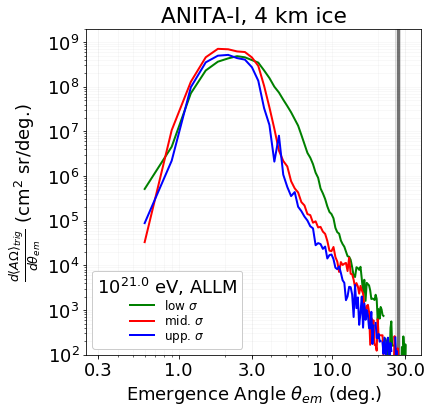

In [94]:
e1 = 1.
e2= 21.
fig, ax = pyp.subplots(figsize=(6,6))
cross_section_comparison(37, 4, 180, 1200, 10., 1, e1, e2, which='anita1')
ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
pyp.xlim(0.25)
pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_anita1_cross_ice%dkm_%de%2.1f.pdf"%(icethick,e1,e2),bbox_inches='tight')

0
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
1
Ref. $10^{20.0}$ eV
Ref. $10^{20.0}$ eV
Ref. $10^{20.0}$ eV
2
Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV


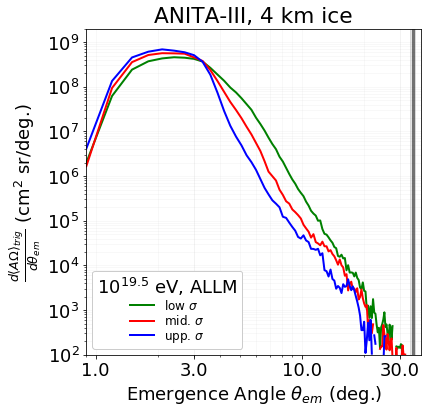

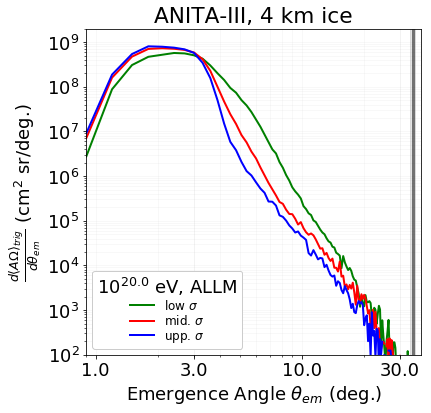

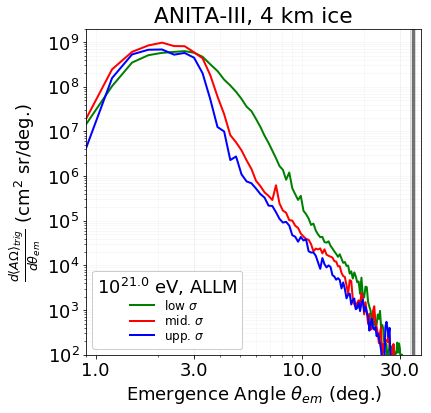

In [95]:
e1_arr = [3.0, 1.0, 1.0]
e2_arr = [19.0, 20.0, 21.0]
eloss = 'std'
which_anita='anita3'
for i,e1 in enumerate(e1_arr):
    e2 = e2_arr[i]
    print i
    fig, ax = pyp.subplots(num=i,figsize=(6,6))#pyp.figure(i+1,figsize=(6,4))
    cross_section_comparison(37, 4, 180, 1200, 10., 1, e1,e2, eloss=eloss,which=which_anita)
    ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    pyp.xlim(0.9)

    pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_%s_cross_%s_ice%dkm_%de%2.1f.pdf"%(which_anita, eloss,icethick,e1,e2),bbox_inches='tight')
    #pyp.clf()

0
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
1
Ref. $10^{20.0}$ eV
Ref. $10^{20.0}$ eV
Ref. $10^{20.0}$ eV
2
Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV


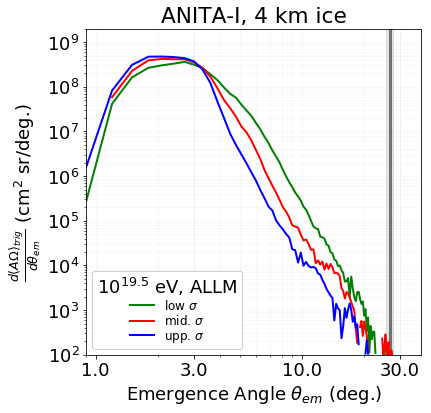

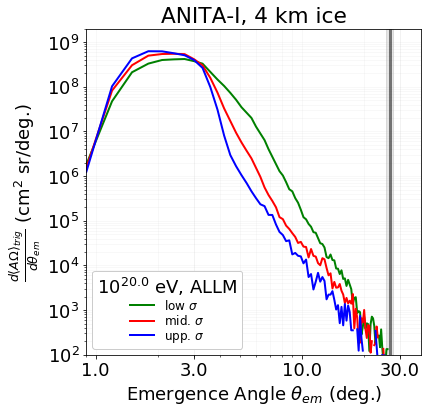

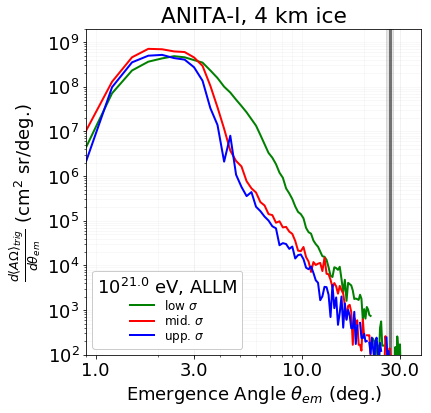

In [96]:
e1_arr = [3.0, 1.0, 1.0]
e2_arr = [19.0, 20.0, 21.0]
eloss = 'std'
which_anita='anita1'
for i,e1 in enumerate(e1_arr):
    e2 = e2_arr[i]
    print i
    fig, ax = pyp.subplots(num=i,figsize=(6,6))#pyp.figure(i+1,figsize=(6,4))
    cross_section_comparison(37, 4, 180, 1200, 10., 1, e1,e2, eloss=eloss,which=which_anita)
    ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    pyp.xlim(0.9)

    pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_%s_cross_%s_ice%dkm_%de%2.1f.pdf"%(which_anita, eloss,icethick,e1,e2),bbox_inches='tight')
    #pyp.clf()

Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV


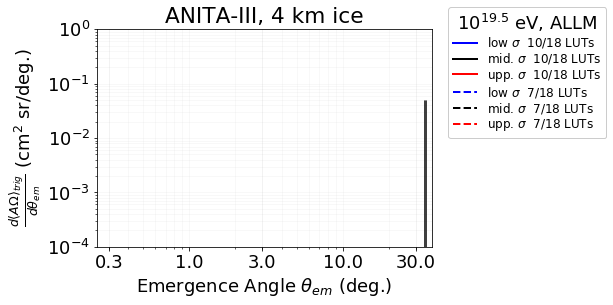

In [97]:
e1_arr = [3.0, ]
e2_arr = [19.0]
eloss = 'std'
which_anita='anita3'
for i,e1 in enumerate(e1_arr):
    e2 = e2_arr[i]
    fig, ax = pyp.subplots(num=i,figsize=(6,4))#pyp.figure(i+1,figsize=(6,4))
    ntrig_comparison(37, 4, 180, 1200, 10., 1, e1,e2, eloss=eloss,which=which_anita, suffix=' 10/18 LUTs')
    ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    pyp.xlim(0.25)
    
    #fig, ax = pyp.subplots(num=i,figsize=(6,4))#pyp.figure(i+1,figsize=(6,4))
    ntrig_comparison(37, 4, 180, 1200, 10., 1, e1,e2, eloss=eloss,which=which_anita + "_july2018", suffix=' 7/18 LUTs')
    ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    pyp.xlim(0.25)
    #pyp.clf()
    pyp.ylim(1e-4,1)
    pyp.savefig(os.environ['TAU_DIR']+"/plots/ntrig_compare_%s_cross_%s_ice%dkm_%de%2.1f.pdf"%(which_anita, eloss,icethick,e1,e2),bbox_inches='tight')


Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{20.0}$ eV
Ref. $10^{20.0}$ eV
Ref. $10^{20.0}$ eV
Ref. $10^{20.0}$ eV
Ref. $10^{20.0}$ eV
Ref. $10^{20.0}$ eV
Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV
Ref. $10^{21.0}$ eV


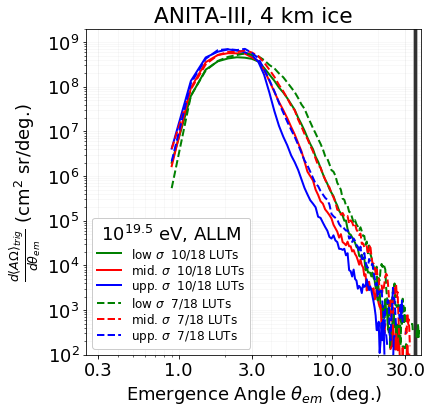

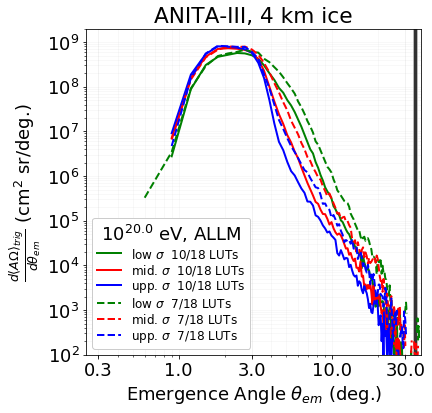

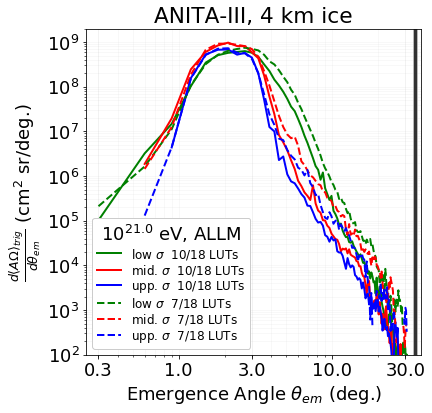

In [98]:
e1_arr = [3.0, 1.0, 1.0]
e2_arr = [19.0, 20.0, 21.0]
eloss = 'std'
which_anita='anita3'
for i,e1 in enumerate(e1_arr):
    e2 = e2_arr[i]
    fig, ax = pyp.subplots(num=i,figsize=(6,6))#pyp.figure(i+1,figsize=(6,4))
    cross_section_comparison(37, 4, 180, 1200, 10., 1, e1,e2, eloss=eloss,which=which_anita, suffix=' 10/18 LUTs')
    ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    pyp.xlim(0.25)
    
    #fig, ax = pyp.subplots(num=i,figsize=(6,6))#pyp.figure(i+1,figsize=(6,4))
    cross_section_comparison(37, 4, 180, 1200, 10., 1, e1,e2, eloss=eloss,which=which_anita + "_july2018", suffix=' 7/18 LUTs')
    ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    pyp.xlim(0.25)

    pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_compare_%s_cross_%s_ice%dkm_%de%2.1f.pdf"%(which_anita, eloss,icethick,e1,e2),bbox_inches='tight')
    #pyp.clf()

Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV
Ref. $10^{19.5}$ eV


KeyError: 'emerge_angle_bins is not a file in the archive'

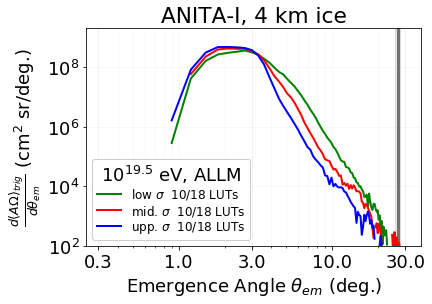

In [99]:
e1_arr = [3.0, 1.0, 1.0]
e2_arr = [19.0, 20.0, 21.0]
eloss = 'std'
which_anita='anita1'
for i,e1 in enumerate(e1_arr):
    e2 = e2_arr[i]
    fig, ax = pyp.subplots(num=i,figsize=(6,4))#pyp.figure(i+1,figsize=(6,4))
    cross_section_comparison(37, 4, 180, 1200, 10., 1, e1,e2, eloss=eloss,which=which_anita, suffix=' 10/18 LUTs')
    ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    pyp.xlim(0.25)
    
    #fig, ax = pyp.subplots(num=i,figsize=(6,4))#pyp.figure(i+1,figsize=(6,4))
    cross_section_comparison(37, 4, 180, 1200, 10., 1, e1,e2, eloss=eloss,which=which_anita + "_july2018", suffix=' 7/18 LUTs')
    ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    pyp.xlim(0.25)
    #pyp.ylim(1e5,7e8)
    pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_compare_%s_cross_%s_ice%dkm_%de%2.1f.pdf"%(which_anita, eloss,icethick,e1,e2),bbox_inches='tight')
    #pyp.clf()

In [ ]:
e1_arr = [1.0, 1.0, 1.0]
e2_arr = [17.0, 18.0, 19.0]
eloss = 'std'
which_anita='anita1'
for i,e1 in enumerate(e1_arr):
    e2 = e2_arr[i]
    fig, ax = pyp.subplots(num=i,figsize=(6,4))#pyp.figure(i+1,figsize=(6,4))
    cross_section_comparison(37, 4, 180, 1200, 10., 1, e1,e2, eloss=eloss,which=which_anita, suffix=' 10/18 LUTs')
    ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    pyp.xlim(0.25)
    
    #fig, ax = pyp.subplots(num=i,figsize=(6,4))#pyp.figure(i+1,figsize=(6,4))
    cross_section_comparison(37, 4, 180, 1200, 10., 1, e1,e2, eloss=eloss,which=which_anita + "_july2018", suffix=' 7/18 LUTs')
    ax.set_xticks(np.array([0.1,0.3,1., 3., 10, 30.]))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    pyp.xlim(0.25)
    pyp.ylim(1e5,7e8)
    pyp.savefig(os.environ['TAU_DIR']+"/plots/diffacceptance_compare_%s_cross_%s_ice%dkm_%de%2.1f.pdf"%(which_anita, eloss,icethick,e1,e2),bbox_inches='tight')
    #pyp.clf()